In [17]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from IPython.display import display_markdown

In [2]:
import en_vectors_web_lg
nlp = en_vectors_web_lg.load()

In [3]:
MAX_WORDS_IN_SENTENCE = 200
TEXT_COLUMN = "Text"
LIMIT = -1
dataset_id = 'food_{}_{}'.format(TEXT_COLUMN.lower(), LIMIT if LIMIT > 0 else 'all')

In [4]:
from sklearn.model_selection import train_test_split
from shared.data import load_fine_food_reviews

X, y = load_fine_food_reviews(limit=LIMIT, text_column=TEXT_COLUMN)

# we're limiting test count to 2000 due to memory problems with higher values
indices = np.arange(len(X))
test_count = min(2000, int(0.25 * len(X)))
idx_train, idx_test = train_test_split(indices, test_size=test_count, random_state=42)

In [5]:
import pandas as pd
data = pd.DataFrame({'X': pd.Series(X), 'y': pd.Series(y[:, 0])})

display_markdown("### Data sample", raw=True)
display(data.head(10))

display_markdown('#### Text stats', raw=True)
display(data.X.describe())

display_markdown('#### Words length stats', raw=True)
display(data.X.apply(lambda w: len(w.split())).describe())

display_markdown('#### Labels stats', raw=True)
display(data.y.describe())

display_markdown('#### Labels counts', raw=True)
display(data.y.value_counts())
display(data.y.value_counts(normalize=True))

display_markdown('### Train count: {}'.format(len(idx_train)), raw=True)
display_markdown('### Test count:  {}'.format(len(idx_test)), raw=True)

# it's no longer needed, just for presentational purposes
del data

### Data sample

,X,y
0,i have bought several of the vitality canned d...,1
1,product arrived labeled as jumbo salted peanut...,0
2,this is a confection that has been around a fe...,1
3,if you are looking for the secret ingredient i...,0
4,great taffy at a great price. there was a wid...,1
5,i got a wild hair for taffy and ordered this f...,1
6,this saltwater taffy had great flavors and was...,1
7,this taffy is so good. it is very soft and ch...,1
8,right now i'm mostly just sprouting this so my...,1
9,this is a very healthy dog food. good for thei...,1


#### Text stats

count                                                525814
unique                                               363827
top       this review will make me sound really stupid, ...
freq                                                    199
Name: X, dtype: object

#### Words length stats

count    525814.000000
mean         79.016667
std          78.447587
min           3.000000
25%          33.000000
50%          55.000000
75%          96.000000
max        2520.000000
Name: X, dtype: float64

#### Labels stats

count    525814.000000
mean          0.843981
std           0.362874
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: y, dtype: float64

#### Labels counts

1    443777
0     82037
Name: y, dtype: int64

1    0.843981
0    0.156019
Name: y, dtype: float64

### Train count: 523814

### Test count:  2000

#### Training or loading model

Loading model...
Unable to load model, training...
Epoch 1/5
4093/4093 [==============================] - 154s 38ms/step - loss: 0.1098 - acc: 0.8980 - val_loss: 0.0812 - val_acc: 0.9170
Epoch 2/5
4093/4093 [==============================] - 160s 39ms/step - loss: 0.0748 - acc: 0.9223 - val_loss: 0.1018 - val_acc: 0.8820
Epoch 3/5
4093/4093 [==============================] - 167s 41ms/step - loss: 0.0720 - acc: 0.9234 - val_loss: 0.0718 - val_acc: 0.9270
Epoch 4/5
4093/4093 [==============================] - 146s 36ms/step - loss: 0.0702 - acc: 0.9238 - val_loss: 0.0813 - val_acc: 0.9100
Epoch 5/5
4093/4093 [==============================] - 148s 36ms/step - loss: 0.0693 - acc: 0.9241 - val_loss: 0.0737 - val_acc: 0.9125
Model 'keras_food_text_all_b3f214f0.h5' saved


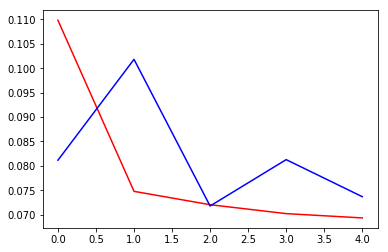

In [16]:
from shared.models import KerasModel
from machine_learning.plot_helpers import plot_training

display_markdown('#### Training or loading model', raw=True)

model = KerasModel(
    nlp, dataset_id, 
    max_words_in_sentence=MAX_WORDS_IN_SENTENCE, 
    epochs=5)

try:
    print("Loading model...")
    model.load()
    print("Model '{}' loaded".format(model.filename))
except IOError:
    print("Unable to load model, training...")
    history = model.train(X, y, idx_train, idx_test)
    model.save()
    print("Model '{}' saved".format(model.filename))
    plot_training(history)

In [7]:
display_markdown("#### Overview of created convolutional network architecture", raw=True)

display(model.summary())

#### Overview of created convolutional network architecture

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 196, 32)           48032     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 39, 32)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 39, 32)            128       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 64)            10304     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
__________

None

In [15]:
from sklearn import pipeline
from shared import transformers

raw_samples = np.array([
    "We went there to eat dinner, and it was delicious",
    "One of the best suppers I've ever eaten",
    "Totally disgusting dish. I think cook made this with his eyes closed"
], dtype='object')

display_markdown("#### Raw text", raw=True)

for text in raw_samples:
    display(text)

display_markdown("#### Cleaned text", raw=True)

clear_pipeline = pipeline.Pipeline([
    ('clear', transformers.ClearTextTransformer()),
])

for text in clear_pipeline.transform(raw_samples):
    display(text)

display_markdown("#### Predicted scores", raw=True)
with pd.option_context("display.max_colwidth", -1):
    display(pd.DataFrame({
        "text": pd.Series(raw_samples),
        "score": pd.Series(model.predict_proba(raw_samples)[:, 1].reshape(len(raw_samples))),
    }))


#### Raw text

'We went there to eat dinner, and it was delicious'

"One of the best suppers I've ever eaten"

'Totally disgusting dish. I think cook made this with his eyes closed'

#### Cleaned text

'we went there to eat dinner and it was delicious'

"one of the best suppers i've ever eaten"

'totally disgusting dish i think cook made this with his eyes closed'

#### Predicted scores

,score,text
0,0.946423,"We went there to eat dinner, and it was delicious"
1,0.979501,One of the best suppers I've ever eaten
2,0.040852,Totally disgusting dish. I think cook made this with his eyes closed


In [10]:
from machine_learning.plot_helpers import plot_confusion_matrix, pandas_settings
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import binarize


# if you want to see whole review, change max_coldwith setting to -1
@pandas_settings(display__max_colwidth=130, display__float_format = '{:.6f}'.format)
def check_model(X_test, y_test, model, show_top_n=5):   
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = binarize(y_pred_proba.reshape(len(y_pred_proba), 1), 0.5)
    
    dt = pd.DataFrame({
        'text': pd.Series(X_test), 
        'prob': pd.Series(y_pred_proba),
        'pred': pd.Series(y_pred.reshape(len(y_pred))),
        'real': pd.Series(y_test.reshape(len(y_test)))
    })
    
    display_markdown("#### Highest {}".format(show_top_n), raw=True)
    display(dt.nlargest(show_top_n, 'prob'))
    
    display_markdown("#### Lowest {}".format(show_top_n), raw=True)
    display(dt.nsmallest(show_top_n, 'prob'))    
    
    display_markdown("#### Highest {} mispredicted".format(show_top_n), raw=True)
    display(dt[dt.pred != dt.real].nlargest(show_top_n, 'prob'))
    
    display_markdown("#### Lowest {} mispredicted".format(show_top_n), raw=True)
    display(dt[dt.pred != dt.real].nsmallest(show_top_n, 'prob'))    
    
    display_markdown("#### Classification report for {}".format(model.NAME), raw=True)
    classes = ['Negative', 'Positive']    
    print(classification_report(y_test, y_pred, target_names=classes))
    plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes)

#### Highest 5

,pred,prob,real,text
1272,1.000000,0.999965,1,"these k-cups are great! the coffee is mild and yummy, but still very flavorful. i love this, cant wait to get my next shipment!"
753,1.000000,0.999963,1,"these apple chips are delicious and healthy for you. they are the perfect snack, especially if you are on a gluten free diet. ..."
1206,1.000000,0.999956,1,i love coconut oil for it's high heat tolerance and for putting a great color on veggies but i don't always want the hefty coc...
1935,1.000000,0.999948,1,"fabulous tea! yum! well balanced and flavorful, i like making a large pot at a time. sometimes for a little more ""bite"" or bec..."
144,1.000000,0.999943,1,i generally do not like powdered creamers but coffee mate has the best tasting creamer!! the vanilla is awesome but the vanill...


#### Lowest 5

,pred,prob,real,text
1493,0.000000,0.000590,0,i purchased these pepperidge farm cookies for a family member that is sick in the hospital. the cookies had an expiration date...
17,0.000000,0.000770,0,this coffee smells and tastes absolutely disgusting. it smells like sugared rubbing alcohol. it tastes like vomit. i have n...
1392,0.000000,0.002541,0,this should be called sad baby--it's awful. my baby absolutely hates it! i tasted a tiny bit<br />and it was bland to the poin...
182,0.000000,0.004607,0,"this was a waste of money on my part as this powder taste awful in tea, which is why i purchased it. it did not have a honey t..."
825,0.000000,0.004721,0,i think my dog was just too smart for this toy. i purchased one of the larger ones with the rubber rope. after 5 minutes of ...


#### Highest 5 mispredicted

,pred,prob,real,text
1714,1.000000,0.998649,0,not so great lemon flavor!<br />it's very hard to find soy free!<br />this is a great brand! i prefer the ginger much better t...
1894,1.000000,0.998151,0,"my 10-month old loves these! they are helpful to teach him how to eat and relieve pain from teething, too. look around for a b..."
998,1.000000,0.996062,0,"wolfgang puck's ""breakfast in bed"" is a much more flavorful and robust medium roast than this one."
1717,1.000000,0.994741,0,"the first couple of bags were great. really fresh, smooth, great taste. i thought i'd found the perfect coffee bean!! the next..."
1500,1.000000,0.991699,0,i found no benefit in taking the kirkland energy shot where the 5 hour energy has me going in a few of minutes.<br /><br />in ...


#### Lowest 5 mispredicted

,pred,prob,real,text
1181,0.000000,0.016157,1,"one of the three packs was open before arriving. the paste was oozing out the side. i can't return it, and i am having a lot..."
402,0.000000,0.023640,1,these jelly beans are great for a party activity (think harry potter) or as a gag gift. there are 5-6 different colors of jell...
380,0.000000,0.038121,1,"yep, great little convenient packets of stevia for sweetening. my recommendation would be to use half of a packet at a time. ..."
393,0.000000,0.059590,1,"the popcorn is great. unfortunately, the bags are defective and the buttery flavoring has seeped out thus making the outside ..."
38,0.000000,0.100705,1,"we just ordered the ""very berry"" and the ""tropical fruit"" arrived in the same box.<br /><br />berry - not crunchy at all. almo..."


#### Classification report for keras

             precision    recall  f1-score   support

   Negative       0.87      0.52      0.65       313
   Positive       0.92      0.99      0.95      1687

avg / total       0.91      0.91      0.90      2000



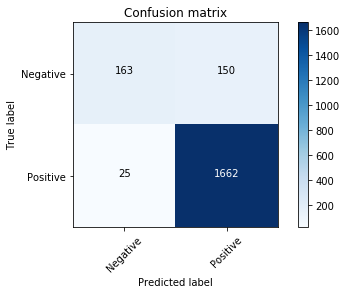

In [11]:
check_model(X[idx_test], y[idx_test], model)